<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия." data-toc-modified-id="Линейная-регрессия.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия.</a></span></li><li><span><a href="#Случайный-лес." data-toc-modified-id="Случайный-лес.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес.</a></span></li><li><span><a href="#Light-GBM.-(здесь-код-закомментил,-чтобы-долго-не-ждать-выполнение)" data-toc-modified-id="Light-GBM.-(здесь-код-закомментил,-чтобы-долго-не-ждать-выполнение)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Light GBM. (здесь код закомментил, чтобы долго не ждать выполнение)</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# не получалось никак импортировать seasonal_decompose, даже загружая обновления,
# воспользовался таким костылем.

import  scipy.signal.signaltools
 
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]
 
scipy.signal.signaltools._centered = _centered
 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) #для вывода всех столбцов на экран
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV# для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выполним ресемплирование данных по одному часу.**

In [5]:
df = df.resample('1H').sum()
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [6]:
#проверим данные на монотонность
print(df.index.is_monotonic)

True


**Данные монотонны.**

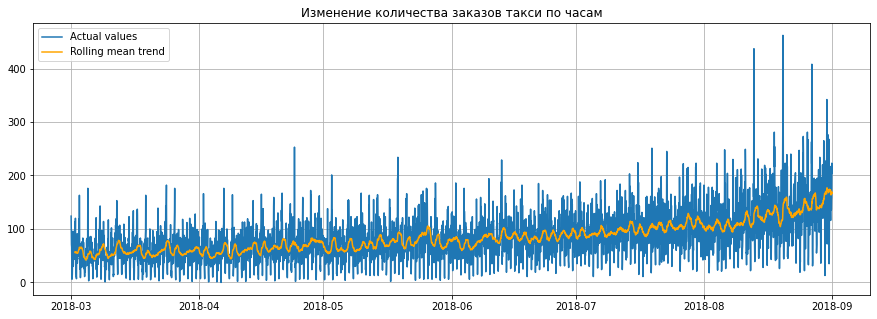

In [7]:
#Построим график изменения данных.
rolling_mean = df.rolling(24).mean()

plt.figure(figsize=(15,5))
plt.title("Изменение количества заказов такси по часам")

plt.plot(df, label="Actual values")
plt.plot(rolling_mean, label="Rolling mean trend", color='orange')
plt.legend()
plt.grid(True)




**Благодаря скользящему среднему с размером окна в 1 день мы видим, что происходит непрерывный рост количества заказов такси.**

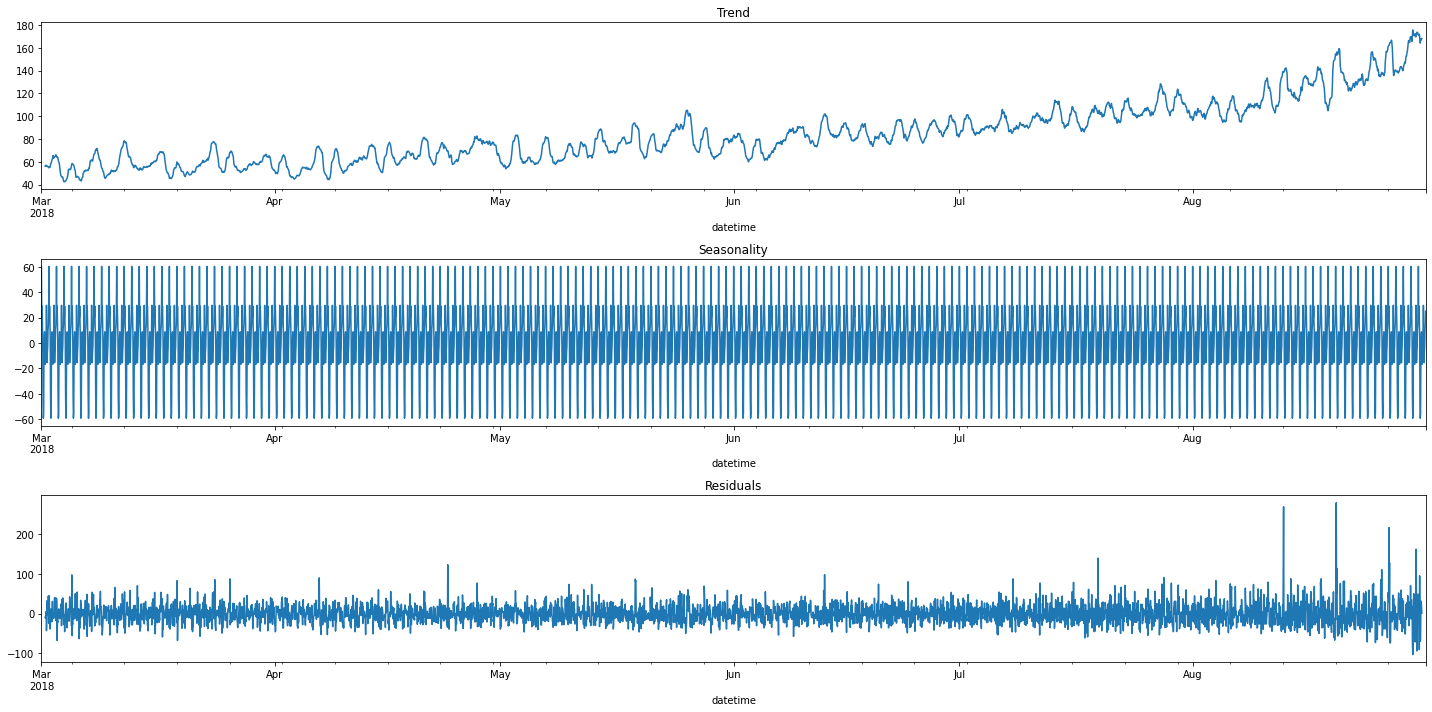

In [8]:
#Декомпозируем и посмотрим тренды и сезонность.
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(20, 10))

plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot()
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')

plt.tight_layout()

**График тренда подтвердил рост количества заказов. Сезонность посмотрим подробнее на срезе нескольких дней.**

<AxesSubplot:title={'center':'Сезонность заказов в течении 7 дней'}, xlabel='datetime'>

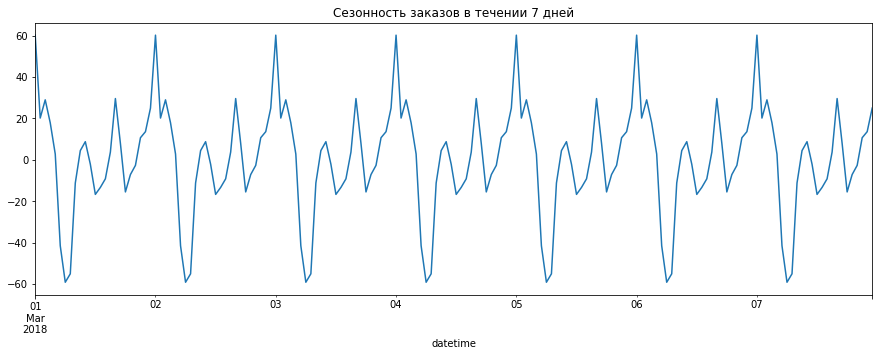

In [9]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течении 7 дней")
decomposed.seasonal['2018-03-01':'2018-03-7'].plot()

**График сезонности показывает нам одинаковое поведение заказов внутри каждого дня. Пик в полноч, затем спад, и с наступлением вечера опять подъем.**

## Обучение

**Создадим дополнительные признаки для последующего обучения моделей. Так как стоит задача прогноза на час вперед, то такие признаки как месяц и год включать не будем. Добавим лаги на час и 2 часа, скользяещее среднее с окном в 24 часа.**

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    return data

In [12]:
df_1 = make_features(df, 2, 24)
df_1.head(25)

,num_orders,hour,dayofweek,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.0,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.0,124.0
2018-03-01 03:00:00,66,3,3,NaN,71.0,85.0
2018-03-01 04:00:00,43,4,3,NaN,66.0,71.0
2018-03-01 05:00:00,6,5,3,NaN,43.0,66.0
2018-03-01 06:00:00,12,6,3,NaN,6.0,43.0
2018-03-01 07:00:00,15,7,3,NaN,12.0,6.0
2018-03-01 08:00:00,34,8,3,NaN,15.0,12.0


**Разделим данные на обучающую и тестовые выборки и проверим корректность деления.**

In [13]:
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [14]:
#уберем пропуски в train
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   hour          3950 non-null   int64  
 2   dayofweek     3950 non-null   int64  
 3   rolling_mean  3950 non-null   float64
 4   lag_1         3950 non-null   float64
 5   lag_2         3950 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 216.0 KB


/tmp/ipykernel_171/2562186900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [15]:
#Создадим обучающие и целевой признаки.
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [16]:
#Создадим функцию для вычисления метрики RMSE. Далее она будет использована при подборе гиперпраметров.
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

**Переходим к обучению различных моделей. Проверим действие 3-х моделей: линейная регрессия, случайный лес, LightGBM. Поиск гиперпараметров будем проводить с помощью метода RandomSearchCV и метода TimeSeriesSplit.**

### Линейная регрессия.

In [17]:
tscv = TimeSeriesSplit(n_splits=8)

In [18]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)

print("RMSE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 3/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 4/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 5/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 6/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 7/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 8/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 1/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 2/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 3/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 4/8] END ............fit_intercept=True, norm

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 3/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
[CV 4/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
[CV 5/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
[CV 6/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
[CV 7/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
[CV 8/8] END ...........fit_intercept=False, normalize=False; total time=   0.0s
RMSE линейной регрессии составляет  31.35975504360978
Наилучшие подобранные параметры для линейной регрессии


{'normalize': True, 'fit_intercept': False}

**Наилучший для линейной регрессии RMSE 31.4, получен для параметров: 'normalize': True, 'fit_intercept': False.**

###  Случайный лес.

In [19]:
forest = RandomForestRegressor(random_state=12345)   
forest_params = {'n_estimators': range(30, 151, 10), 'max_depth': range(1,10)}
forest_grid = RandomizedSearchCV(forest, forest_params, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
forest_grid.fit(features_train, target_train)

print("RMSE для случайного леса составляет ", -forest_grid.best_score_)
print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END ...................max_depth=9, n_estimators=40; total time=   0.1s
[CV 2/8] END ...................max_depth=9, n_estimators=40; total time=   0.1s
[CV 3/8] END ...................max_depth=9, n_estimators=40; total time=   0.1s
[CV 4/8] END ...................max_depth=9, n_estimators=40; total time=   0.1s
[CV 5/8] END ...................max_depth=9, n_estimators=40; total time=   0.2s
[CV 6/8] END ...................max_depth=9, n_estimators=40; total time=   0.2s
[CV 7/8] END ...................max_depth=9, n_estimators=40; total time=   0.2s
[CV 8/8] END ...................max_depth=9, n_estimators=40; total time=   0.2s
[CV 1/8] END ...................max_depth=1, n_estimators=70; total time=   0.1s
[CV 2/8] END ...................max_depth=1, n_estimators=70; total time=   0.1s
[CV 3/8] END ...................max_depth=1, n_estimators=70; total time=   0.1s
[CV 4/8] END ...................max_depth=1, n_e

**Наилучший  для случайного леса RMSE 25.1, получен для параметров: 'n_estimators': 50, 'max_depth': 9.**

### Light GBM. (здесь код закомментил, чтобы долго не ждать выполнение)

In [20]:
'''lgbm = LGBMRegressor(random_state=12345) 
lg_params = {'n_estimators': [50, 100, 500], 'num_leaves': [21, 31, 41], 'learning_rate':[0.01, .04, 0.06]}
lg_grid = RandomizedSearchCV(lgbm, lg_params, cv=tscv, verbose=5, scoring=scorer)
lg_grid.fit(features_train, target_train)

print("RMSE для LGBM составляет ", -lg_grid.best_score_)
print('Наилучшие подобранные параметры для LGBM')
print(lg_grid.best_params_)'''

'lgbm = LGBMRegressor(random_state=12345) \nlg_params = {\'n_estimators\': [50, 100, 500], \'num_leaves\': [21, 31, 41], \'learning_rate\':[0.01, .04, 0.06]}\nlg_grid = RandomizedSearchCV(lgbm, lg_params, cv=tscv, verbose=5, scoring=scorer)\nlg_grid.fit(features_train, target_train)\n\nprint("RMSE для LGBM составляет ", -lg_grid.best_score_)\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(lg_grid.best_params_)'

**Наилучший для LGBM RMSE 24.4, получен для параметров: 'num_leaves': 41, 'n_estimators': 100, 'learning_rate': 0.06.**

**Обучены и подобраны гиперпараметры для 3 различных моделей: линейная регрессия, случайный лес, LightGBM. Для всех моделей была применена кросс-валидация с применением метода TimeSeriesSplit.
По заданию требуется значение метрики RMSE менее 48, с этим справились все 3 модели.
Наихудший результат был получен с ппомощью линейной регрессии (31.4), наилучший - с помощью LGBM (24.4). 
Проверим модели с подобранными гиперпараметрами на тестовой выборке.**

## Тестирование

In [21]:
model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5

print("RMSE линейной регрессии составляет:", rmse)

RMSE линейной регрессии составляет: 51.192444258655904


In [22]:
model = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5

print("RMSE случайного леса составляет:", rmse)

RMSE случайного леса составляет: 48.9667998532471


In [23]:
model = LGBMRegressor(num_leaves=41, n_estimators=100, learning_rate=0.06, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5

print("RMSE для модели LGBM составляет:", rmse)

RMSE для модели LGBM составляет: 44.604563244677855


**В отличие от результатов на обучающей выборке, по итогу тестирования только модель LGBM подошла под требование по поставленной метрике RMSE < 48, линейная регрессия и случайный лес - не справились с задачей на тестовой выборке.**